<a href="https://colab.research.google.com/github/JacobDowns/CSCI-491-591/blob/main/lecture3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concurrency and Parallelism




* Before jumping into multiprocessing in Python, it's useful to go over the basic concepts of concurrency and parallelism.
* A nice overview of these concepts is provided in this [article](https://towardsdatascience.com/deep-dive-into-multithreading-multiprocessing-and-asyncio-94fdbe0c91f0/) by Clara Chong
* First, we need to distinguish between concurrency and parallelism

> **Concurrency** is managing multiple tasks at the same time by task switching

> **Parallelism** is about running multiple tasks simultaneously, typically on multiple cores



<figure>
<img src="https://towardsdatascience.com/wp-content/uploads/2024/12/15zUHBzNkzOZYPu1uvuLcSQ.png" width="1000px">
<figcaption align="center"> Concurency v. Parallelism from Clara Chong.
</figure>

## Programs and Processs

* A program refers to a static file like a Python script or executable
* A program is passive until the OS loads it into memory to run
* A running program becomes a **process**

> **Process:**  an independent instance of a running program






* Processes are meant to be isolated from each other by default
* They have their own memory space, resources, and execution state
* Typically processes won't communicate with each other directly explicitly designed to
* For example the Message Passing Interface (MPI), which we'll discuss later, facilitates interprocess communication



## Threads
* Processes have one or more **threads**

> **Thread**: the samallest unit of execution within a process
* Processes essentially act as containers for threads
* Threads can be spawned or destroyed throughout the life cycle of a process.
* Each process has at least one thread called the `main` thread
* Threads for a single process share memory and resources
* Shared memory enables efficient communication, but also presents challenging synchronization problems like race conditions or deadlocks



> **Race Condition**: Occurs when two or more threads can access ahared data and try to change it simultaneously



```
if(x == 5)
  # Between and the line y=x*2 another thread could modify x
  y = x*2
  # Now x is not what you expect, and neither is y
```


> **Deadlock**: Two are more threads become permanently stuck because each thread is waiting for a resource the other holds



## OS Management of Threads and Processes
* Generally, CPUs execute one task per core at a time

> **Note:** This is not quite true, but it can be useful to conceptualize it this way. True parallel execution of processes (in the sense of fully independent scheduling with isolated hardware resources) requires multiple physical cores. However, even a single core can execute multiple threads or instructions simultaneously through mechanisms like hyperthreading, superscalar pipelines, and SIMD.

* So how does the OS handle several threads or processes at once?
* The OS uses preemptive context switching

> During a **context switch** the OS pauses the current task, saves its state and loads the state of the next task to be executed
* Processes do not have full control over when a context switch happens
* Context switching between processes is much more resource-intensive than switching between threads
* This is because the OS must save and load separate memory spaces for processes, but memory is shared between threads









<figure>
<img src="https://towardsdatascience.com/wp-content/uploads/2024/12/1YrsrPOh5y4EL_7UOFJ08yg-1536x858.png" width="1000px">
<figcaption align="center"> Visualization of processes and threads from Clara Chong.
</figure>

## I/O-Bound v. CPU-Bound Processes
* We make a broad distinction between I/O-bound processes and CPU-bound processes
* **I/O bound:** These processes spend most of their time waiting for input/output operations to complete like file access, network communication, or user input while the CPU is mostly idle.

<figure>
<img src="https://realpython.com/cdn-cgi/image/width=1737,format=auto/https://files.realpython.com/media/IOBound.4810a888b457.png" width="1000px">
<figcaption align="center"> Visualization of an I/O-bound process from Jim Anderson.
</figure>

* **CPU-bound:** These processes spend most of their time doing computations, making heavy use of the CPU.

<figure>
<img src="https://realpython.com/cdn-cgi/image/width=1737,format=auto/https://files.realpython.com/media/CPUBound.d2d32cb2626c.png" width="1000px">
<figcaption align="center"> Visualization of a CPU-bound process from Jim Anderson.
</figure>



## Concurrency in Python

There are a few models for achieving concurrency in Python.
### 1. Multithreading

* Multithreading allows a process to execute muiltiple threads concurrently
* In Python, multithreading is limited by the Global Interpreter Lock (GIL)
> The **Global Interpreter Lock** allows only one thread to hold control of the Python interpreter at any time
* This design simplifies memory management in Python, but has consequences for multithreading
* The GIL typically has a limited impact on I/O-bound processes, since they are often waiting
* For multithreaded CPU-bound operations, however, the GIL is a significant bottleneck because multiple threads competing for the GIL take turns executing Python bytecode
* Hence, the main use case for multithreading in Python is for I/O bound tasks
* Notably, multithreading in Python is not true parallelism, it is concurrency

## 2. Multiprocessing
* Multiprocessing enables a system to run multiple processes in parallel
* In Python each of these parallel processes has its own memory, GIL, and other resources
* This introduces additional overhead, but bypasses the limitations imposed by the GIL
* Its primary use is for speeding up CPU bound tasks

## 3. Asyncio
* Asyncio is a little different from threading in that it uses a single thread to handle multiple tasks
* Asyncio runs an event loop that schedules tasks
* Tasks will voluntarily pause themselves when waiting for something like file input or a network response
* During this pause, the event loop switches to another task
* It is also useful for I/O-bound tasks or processes involving many small tasks that spend a lot of time waiting
* There a few main concepts in asyncio


> **Coroutines**: these are functions defined with `async def` that can be paused and resumed

> **Event Loop**: manages the execution of all tasks

> **Tasks**: Wrappers around coroutines. A coroutine is turned into a task to actually run it.

> `await` : This is the keyword that pauses a coroutine. It gives control back to the event loop



# Accelerating an I/O Bound Program

The next few examples are based on the [article](https://realpython.com/python-concurrency/) here by Jim Anderson, which is well worth reading through. For I/O-bound tasks we can benefit from concurrency using mulithreading or asyncio. Consider this example code that downloads the contents of some websites.

In [1]:
import time

import requests

def download_some_stuff():
    sites = [
        "https://www.jython.org",
        "http://olympus.realpython.org/dice",
    ] * 80
    start_time = time.perf_counter()
    download_all_sites(sites)
    duration = time.perf_counter() - start_time
    print(f"Downloaded {len(sites)} sites in {duration} seconds")

def download_all_sites(sites):
    with requests.Session() as session:
        for url in sites:
            download_site(url, session)

def download_site(url, session):
    with session.get(url) as response:
        print(f"Read {len(response.content)} bytes from {url}")

Let's try it out and see how long it takes.

In [2]:
download_some_stuff()

Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice


In [3]:
import threading
import time
from concurrent.futures import ThreadPoolExecutor
import requests

thread_local = threading.local()

def download_some_stuff_threaded():
    sites = [
        "https://www.jython.org",
        "http://olympus.realpython.org/dice",
    ] * 80
    start_time = time.perf_counter()
    download_all_sites(sites)
    duration = time.perf_counter() - start_time
    print(f"Downloaded {len(sites)} sites in {duration} seconds")

def download_all_sites(sites):
    with ThreadPoolExecutor(max_workers=5) as executor:
        executor.map(download_site, sites)

def download_site(url):
    session = get_session_for_thread()
    with session.get(url) as response:
        print(f"Read {len(response.content)} bytes from {url}")

def get_session_for_thread():
    if not hasattr(thread_local, "session"):
        thread_local.session = requests.Session()
    return thread_local.session

In [4]:
download_some_stuff_threaded()

Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 278 bytes from http://olympus.realpython.org/dice
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 278 bytes from http://olympus.realpython.org/dice
Read 10966

What are the main differences here? We're using Python's ThreadPoolExecutor here to manage threads. The `max_workers` parameter defines the number of worker threads that will be created. Recall that the number of threads is not tied to the number of cores available on your machine. So in this case, we've got five threads doing requests and waiting for a response.

These five threads will stay alive until the `with` block has completed and all sites have been downloaded. So, once a thread finishes a request, its fed the next site in sites that hasn't been completed

An important note on this code is that the `Session` object is not thread safe. That is, we cannot reuse just one session object for every thread, because this would lead to race conditions where the session objects could be in the incorrect state for a given thread as other threads modify its properties.

To get around this issue, the line
```
thread_local = threading.local()
```
creates a special object that has thread local storage. It's a sort of conatiner that you can store things that shouldn't be shared among all threads. This function
```
def get_session_for_thread():
    if not hasattr(thread_local, "session"):
        thread_local.session = requests.Session()
    return thread_local.session
```
takes advantage of that thread local storage. When the thread is invoked, there is not a session attribute set in `thread_local`, so this function will create a new `Session` object.  On any subsequent calls in the same thread, it will reuse that local `Session` object.

## Using asyncio

As mentioned, asyncio provides another approach to concurrency that often excels at handling I/O-bound tasks. Let's see the same example of downloading several websites implemented in asyncio.

In [5]:
import asyncio
import time
import aiohttp

async def download_stuff_asyncio():
    sites = [
        "https://www.jython.org",
        "http://olympus.realpython.org/dice",
    ] * 80
    start_time = time.perf_counter()
    await download_all_sites(sites)
    duration = time.perf_counter() - start_time
    print(f"Downloaded {len(sites)} sites in {duration} seconds")

async def download_all_sites(sites):
    async with aiohttp.ClientSession() as session:
        tasks = [download_site(url, session) for url in sites]
        await asyncio.gather(*tasks, return_exceptions=True)

async def download_site(url, session):
    async with session.get(url) as response:
        print(f"Read {len(await response.read())} bytes from {url}")


In [6]:
await download_stuff_asyncio()

Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966 bytes from https://www.jython.org
Read 10966

What are the key differences in the asyncio version? First, we switched from using the requests library to `aiohttp`. This is because `aiohttp` is designed to work with asyncio because it's non-blocking. Thus, if a request is made in `aiohttp`, it doesn't inhibit control being released back to the event loop.

The function `download_all_sites` is creates a single `Session` object. Unlike the threaded version, this is fine because everything runs on a single thread in asyncio. This line creates a list of tasks to be completed
```
tasks = [download_site(url, session) for url in sites]
```
but because they async functions, they are not run immediately. The functions need to be awaited to actually run. Next, the line
```
await asyncio.gather(*tasks, return_exceptions=True)
```
uses a `asyncio.gather()` to run all the tasks concurrently.

**Notes:**
* Unlike threading, there is no notion of the number of the optimal number of workers or threads in asyncio. Task switching is done according to when functions release control back to the event loop.
* The default, synchronous version showed deterministic behavior. That is, every site was downloaded in a particular order. The multithreaded and asynchronous versions are non-deterministic.
* You need special asynchronous versions of libraries to gain the full advantage of asyncio. For example, using `requests` as opposed to `aiohttp` would've been slow because the `async` functions wouldn't have given up control.
* Small mistakes in code can have a big impact because a coroutine needs to give up control voluntarily.
* You could also use multiprocessing for this task, but it ends up being barely faster than the synchronous version.




## Accelerating an I/O Bound Program

Next, we'll shift to a CPU bound problem. Let's consider a recursive implementation of the Fibonacci sequence.

In [7]:
def fib(n):
    return n if n < 2 else fib(n - 2) + fib(n - 1)

In [8]:
import time

def run_synchronous():
    start_time = time.perf_counter()
    for _ in range(10):
        fib(38)
    duration = time.perf_counter() - start_time
    print(f"Computed in {duration} seconds")



In [9]:
run_synchronous()

Computed in 31.64398568499928 seconds


That took a while. What if we tried to speed it up with multithreading?

In [10]:
import time
from concurrent.futures import ThreadPoolExecutor

def run_threaded():
    start_time = time.perf_counter()
    with ThreadPoolExecutor(max_workers=5) as executor:
        executor.map(fib, [38] * 10)
    duration = time.perf_counter() - start_time
    print(f"Computed in {duration} seconds")


In [11]:
run_threaded()

Computed in 42.23928950899972 seconds


This was even slower than the standard Python version due to overhead of switching between threads. This is a problem that benefits from multiprocessing.

In [ ]:
import time
from concurrent.futures import ProcessPoolExecutor

def run_parallel():
    start_time = time.perf_counter()
    with ProcessPoolExecutor(max_workers=2) as executor:
        executor.map(fib, [38] * 10)
    duration = time.perf_counter() - start_time
    print(f"Computed in {duration} seconds")

In [ ]:
run_parallel(
    2
)

Computed in 15.787282847000824 seconds


For this CPU bound problem, multiprocessing provides a substantial performance increase. Indeed, on my machine this took almost exactly half the time of the synchronous version. 

## Parallel Performance Scaling
How does performance scale as we add more processors? In theory, on this task, the time should scale inversely with the number or processors we use. 

In [51]:
def run_parallel(max_workers):
    start_time = time.perf_counter()
    with ProcessPoolExecutor(max_workers) as executor:
        executor.map(fib, [38] * 10)
    duration = time.perf_counter() - start_time
    return duration 

In [43]:
times = []
for i in range(1,14):
    print(f'Running on {i} processor(s).')
    t = run_parallel(i)
    times.append(t)
    print(f'Took {t} seconds.')

Running on 1 processor(s).
Took 31.56438967899885 seconds.
Running on 2 processor(s).
Took 15.805733072000294 seconds.
Running on 3 processor(s).
Took 12.636884308001754 seconds.
Running on 4 processor(s).
Took 9.477804975998879 seconds.
Running on 5 processor(s).
Took 6.454539813999872 seconds.
Running on 6 processor(s).
Took 6.369663725999999 seconds.
Running on 7 processor(s).
Took 6.345318141000462 seconds.
Running on 8 processor(s).
Took 6.376174231998448 seconds.
Running on 9 processor(s).
Took 6.349347348997981 seconds.
Running on 10 processor(s).
Took 3.9411018760001753 seconds.
Running on 11 processor(s).
Took 4.223324272999889 seconds.
Running on 12 processor(s).
Took 4.185547403001692 seconds.
Running on 13 processor(s).
Took 4.18327516899808 seconds.


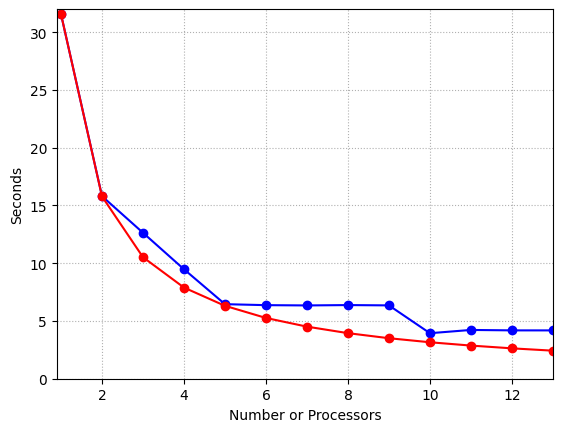

In [50]:
import matplotlib.pyplot as plt
import numpy as np 
procs = np.arange(1,14)
plt.plot(procs, times, 'bo-', label='Real Time')
plt.xlabel('Number or Processors')
plt.ylabel('Seconds')
plt.grid(True, linestyle=':')
plt.plot(procs, times[0] / procs, 'ro-', label = 'Theoretical Time')
plt.xlim([0.9,13])
plt.ylim([0,32])
plt.show()

For the most part, this is true. We're achieving almost the maximum theoretical speedup that we'd expect. This is an example of an **emberassingly parallel** task where there is no intercommunication required between processes. Hence, each call of `fib` is essentially an independent task. 

## Amdahl's Law

* Suppose that part of our program is easy to parallelize, but another portion of it is serial, meaning it doesn't benefit from parallelism
* Amdahl's law defines the theoretical maximum speedup that can be achieved depending on the portion of the program that is parallelizable. 
* Suppose that a task takes time $T$ to complete when running on a single processor. 
* Let $P$ be the fraction of the task that can be parallelized
* Then $(1-P)$ is the fraction that is sequential or cannot be parallelized
* Let $N$ be the number of processors
* Then the time it takes to complete the task, assuming that the time it takes to finish parallelizable portion of the program scales inversely with the number of processors is

$$T_p = T \left ( (1-P) + \frac{P}{N} \right )$$
* The speedup is then given by by the ratio of the time for the original sequential version $T$ over the time for the parallelized version $T_p$, or 
$$ \frac{T}{T_p} = \frac{1}{  (1-P) + \frac{P}{N} }$$

Let's see some examples of the speedups that can be achieved for different values of P and N. 

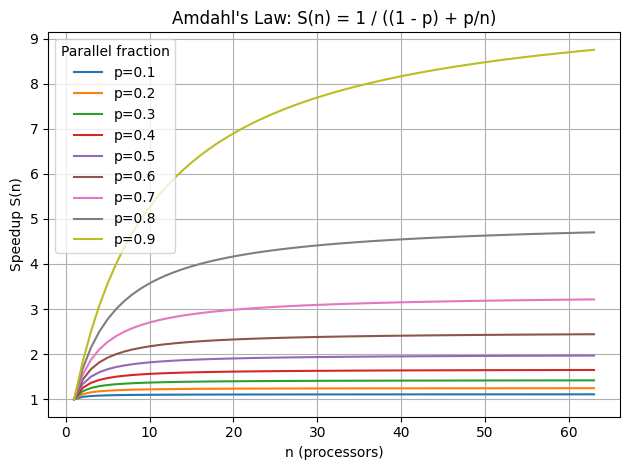

In [63]:
import numpy as np
import matplotlib.pyplot as plt

n = np.arange(1, 64)            # processors 1..32
ps = np.linspace(0.1, 0.9, 9)   # 0.1, 0.2, ..., 0.9

for p in ps:
    S = 1.0 / ((1 - p) + (p / n))
    plt.plot(n, S, label=f"p={p:.1f}")

plt.xlabel("n (processors)")
plt.ylabel("Speedup S(n)")
plt.title("Amdahl's Law: S(n) = 1 / ((1 - p) + p/n)")
plt.legend(title="Parallel fraction")
plt.grid(True)
plt.tight_layout()
plt.show()